Authors: 
*   <font color="blue">Miquel Casas Olivella</font>
*   <font color="blue">Aina Moncho Roig</font>
*   <font color="blue">Marina Suárez Blázquez</font>

# Information Retrieval and Web Analytics

# Part 1: Text Processing

#### Load Python packages
Let's first import all the packages that we will need during this assignment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from numpy import linalg as la
from datetime import datetime
import math
import numpy as np
import collections
import json # this will help us read the file
import re
import pandas as pd 

In [ ]:
import gensim
print(gensim.__version__)

4.2.0


Make sure you have version 4.2.0 of gensim, otherwise run the following cell

In [ ]:
#pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# if you do not have 'nltk', the following command should work "python -m pip install nltk"
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Imports we need for the plot in the second part

In [ ]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups

#### Pre-processing the documents


We are first going to read the tweets using json python's library.

In [ ]:
data = [json.loads(line) for line in open('tw_hurricane_data.json', 'r')]

print('Total number of tweets: {}'.format(len(data)))

Total number of tweets: 4000


1. Removing stop words
2. Tokenization
3. Removing punctuation marks
4. Stemming
5. Bonus point





In [ ]:
def build_terms(line):
  stemmer = PorterStemmer()
  stop_words = set(stopwords.words('english'))
  line = line.lower()
  line = re.sub('http[s]?://\S+', '', line) # BONUS: Remove urls
  line = re.sub('[\W_]+', ' ', line) # BONUS: Remove emojis, simbols...
  line = line.split()  # Tokenize the text to get a list of terms
  line = [x for x in line if x not in stop_words]  # Eliminate the stopwords
  line = [stemmer.stem(word) for word in line] # Perform stemming
  return line

In [ ]:
i = 0
for tweet in data:  # Data contains all tweets

  # Keeping the needed tweet fields
  tweet = {'Tweet': tweet['full_text'], 
           'Username': tweet['user']['name'], 
           'Date': tweet['created_at'], 
           'Hashtags': tweet['entities']['hashtags'],
           'Likes': tweet['favorite_count'],
           'Retweets': tweet['retweet_count'],
           'Url': tweet['entities']['media'][0]['url'] if ( tweet['entities'].get('media') is not None) else {}} # encontrar que url es
  
  # Displaying 5 tweets before processing them
  if i<5:
    print('\033[1m' + 'UNPROCESSED' + '\033[0m')
    print(tweet) 
  
  # Processing each of the fields
  for key in tweet.keys():
    if key == 'Tweet':
      tweet[key]=build_terms(tweet[key]) # Pre-processing the full text
    if key == 'Username':
      tweet[key]=re.sub('[\W_]+',' ',tweet[key]) # Remove emojis, simbols... from username    
    if key == 'Date':
      tweet[key]=datetime.strptime(tweet[key], '%a %b %d %H:%M:%S %z %Y') # Changing Date format into an understandable format for python
    if key == 'Hashtags':
      tweet[key]=[hashtag['text'] for hashtag in tweet[key]] # Creating a list of all hashtags (without indices)     
  
  # Displaying 5 tweets after processing them
  if i<5:
    print('\033[1m' + 'PROCESSED' + '\033[0m')
    print(tweet, '\n') 

  data[i] = tweet
  i += 1 

UNPROCESSED
{'Tweet': 'So this will keep spinning over us until 7 pm…go away already. #HurricaneIan https://t.co/VROTxNS9rz', 'Username': 'Suz👻', 'Date': 'Fri Sep 30 18:39:08 +0000 2022', 'Hashtags': [{'text': 'HurricaneIan', 'indices': [63, 76]}], 'Likes': 0, 'Retweets': 0, 'Url': 'https://t.co/VROTxNS9rz'}
PROCESSED
{'Tweet': ['keep', 'spin', 'us', '7', 'pm', 'go', 'away', 'alreadi', 'hurricaneian'], 'Username': 'Suz ', 'Date': datetime.datetime(2022, 9, 30, 18, 39, 8, tzinfo=datetime.timezone.utc), 'Hashtags': ['HurricaneIan'], 'Likes': 0, 'Retweets': 0, 'Url': 'https://t.co/VROTxNS9rz'} 

UNPROCESSED
{'Tweet': 'Our hearts go out to all those affected by #HurricaneIan. We wish everyone on the roads currently braving the conditions safe travels. 💙', 'Username': 'Lytx', 'Date': 'Fri Sep 30 18:39:01 +0000 2022', 'Hashtags': [{'text': 'HurricaneIan', 'indices': [43, 56]}], 'Likes': 0, 'Retweets': 0, 'Url': {}}
PROCESSED
{'Tweet': ['heart', 'go', 'affect', 'hurricaneian', 'wish', 'everyo

In [ ]:
df = pd.DataFrame.from_dict(data) # Converting the list of dictionaries into a dataframe
doc_ids = pd.read_csv('tweet_document_ids_map.csv', names=['doc_id']) # Reading the tweet_document_ids_map
df_final = pd.merge(doc_ids, df, left_index=True, right_index=True) # Mapping the tweets with the document ids
df_final.head(3)

,doc_id,Tweet,Username,Date,Hashtags,Likes,Retweets,Url
0,doc_1\t1575918182698979328,"[keep, spin, us, 7, pm, go, away, alreadi, hur...",Suz,2022-09-30 18:39:08+00:00,[HurricaneIan],0,0,https://t.co/VROTxNS9rz
1,doc_2\t1575918151862304768,"[heart, go, affect, hurricaneian, wish, everyo...",Lytx,2022-09-30 18:39:01+00:00,[HurricaneIan],0,0,{}
2,doc_3\t1575918140839673873,"[kissimme, neighborhood, michigan, ave, hurric...",Christopher Heath,2022-09-30 18:38:58+00:00,[HurricaneIan],0,0,https://t.co/jf7zseg0Fe


# Part 2: Indexing & Evaluation

We are going to split between documentID and tweetID.

In [ ]:
sep1 = df_final["doc_id"].str.split(pat = '\t',expand = True) # the split elements will expand out into separate columns
docID = sep1[0]
tweetID = sep1[1]
df_final["doc_id"] = docID
df_final["tweet_id"] = tweetID

We are also going to order the columns of our DataFrame

In [ ]:
df_final = df_final.loc[:, ["doc_id","tweet_id","Tweet","Username",
           "Date","Hashtags","Likes","Retweets","Url"]]
df_final

,doc_id,tweet_id,Tweet,Username,Date,Hashtags,Likes,Retweets,Url
0,doc_1,1575918182698979328,"[keep, spin, us, 7, pm, go, away, alreadi, hur...",Suz,2022-09-30 18:39:08+00:00,[HurricaneIan],0,0,https://t.co/VROTxNS9rz
1,doc_2,1575918151862304768,"[heart, go, affect, hurricaneian, wish, everyo...",Lytx,2022-09-30 18:39:01+00:00,[HurricaneIan],0,0,{}
2,doc_3,1575918140839673873,"[kissimme, neighborhood, michigan, ave, hurric...",Christopher Heath,2022-09-30 18:38:58+00:00,[HurricaneIan],0,0,https://t.co/jf7zseg0Fe
3,doc_4,1575918135009738752,"[one, tree, backyard, scare, poltergeist, tree...",alex,2022-09-30 18:38:57+00:00,"[scwx, HurricaneIan]",0,0,{}
4,doc_5,1575918119251419136,"[ashleyruizwx, stephan89441722, lilmizzheidi, ...",Tess,2022-09-30 18:38:53+00:00,[HurricaneIan],0,0,{}
...,...,...,...,...,...,...,...,...,...
3995,doc_3996,1575856268022992896,"[cfrd, carrboropd, carrboro, public, work, car...",Carrboro Fire Rescue,2022-09-30 14:33:06+00:00,"[CarrboroSafe, ncwx, HurricaneIan]",2,0,{}
3996,doc_3997,1575856245650919424,"[osceolacountyfl, list, fema, websit, widespre...",BaconBitsNews,2022-09-30 14:33:01+00:00,"[Kissimmee, SaintCloud, BlueCounty, Disney, De...",0,0,{}
3997,doc_3998,1575856228886089728,"[realli, hurricaneian, flood, florida, magatea...",jganyfl,2022-09-30 14:32:57+00:00,"[HurricaneIan, Florida, MAGATears]",16,8,https://t.co/9VPkyjZvWO
3998,doc_3999,1575856226139017216,"[damag, area, punta, gorda, thread, tropic, gu...",CJ Haddad,2022-09-30 14:32:56+00:00,[HurricaneIan],2,1,https://t.co/jcVCdY2FQ6


#### Indexing

1. **Build inverted index:** we are going to create implement a function that given the tweets it will returns its **inverted index** as seen in class. That is with all the terms with an array where we can observe where that word is positioned.

We will also return the pageID.

In [ ]:
def create_index_tfidf(df_final, num_documents):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    lines -- collection of Wikipedia articles
    num_documents -- total number of documents
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """
    lines = df_final['Tweet']
    index = defaultdict(list)
    tf = defaultdict(list)  #term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  #document frequencies of terms in the corpus
    title_index = defaultdict(str)
    idf = defaultdict(float)

    
    
    for i, line in enumerate(lines):  # Remember, lines contain all documents from file
    #line_arr = line.split("|")
    
        page_id = df_final['doc_id'][i]
        ## ===============================================================        
        ## create the index for the **current page** and store it in current_page_index
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is 
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0, 
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_page_index = {}

        for position, term in enumerate(line):  ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term] = [page_id, array('I', [position])]  #'I' indicates unsigned int (int in Python)

        # normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_page_index.items():
            # posting will contain the list of positions for current term in current document. 
            # posting ==> [current_doc, [list of positions]] 
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1]) / norm, 4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents / df[term])), 4)

    return index, tf, df, idf

In [ ]:
index, tf, df, idf = create_index_tfidf(df_final, len(df_final))
word = []
word_df = []
for item in df.items():
    word.append(item[0])
    word_df.append(item[1])

document_frequency_df = pd.DataFrame(list(zip(word,word_df)), columns=['Word', 'DF'])
document_frequency_df.sort_values(by='DF', ascending=False).head(20)

,Word,DF
8,hurricaneian,4000
83,florida,887
53,hurrican,813
81,ian,799
240,help,387
146,amp,362
28,storm,357
98,carolina,304
337,flood,291
327,power,282


2. **Propose test queries:**
We are going to select terms based on the popularity.

- florida wind
- rain flood
- hurricane disaster
- it's storming
- storm winds

Since we are dealing with conjunctive queries (AND), each
of the returned documents should contain all the words in the query. The following function use english Free Text Queries, then for the `query` we will query the index using a sequence of english words as query, and the output will be the list of documents that contain any of the query terms.

In [ ]:
def rank_documents(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    
    Returns:
    Print the list of ranked documents
    and a list with its scores
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        # TODO: check how to vectorize the query
        # query_vector[termIndex]=idf[term]  # original
        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex] = query_terms_count[term] / query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    result_scores = [x[0] for x in doc_scores]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    return result_docs, result_scores

In [ ]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the intersaction of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs = [posting[0] for posting in index[term]]
            
            # docs = docs Intersaction term_docs
            if len(docs) == 0:
              docs = set(term_docs)
            else:
              docs.intersaction(set(term_docs))
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs, result_scores = rank_documents(query, docs, index, idf, tf)
    return ranked_docs, result_scores

Here we are returning the 1st 10 documents that contain those queries, but later on we will return the top K documents based on the popularity with their score.

In [ ]:
queries = ["florida wind", "rain flood", "hurricane disaster", "it's storming", "storm winds"]
for query in queries:
  docs, scores = search_tf_idf(query, index)
  top = 10

  print("\n======================\nSample of {} results out of {} for the searched query -> {}:\n".format(top,len(docs),query))
  for d_id in docs[:top]:
      print("page_id = {}".format(d_id))


Sample of 10 results out of 887 for the searched query -> florida wind:

page_id = doc_2950
page_id = doc_1493
page_id = doc_2945
page_id = doc_32
page_id = doc_1170
page_id = doc_153
page_id = doc_198
page_id = doc_2047
page_id = doc_242
page_id = doc_206

Sample of 10 results out of 138 for the searched query -> rain flood:

page_id = doc_2901
page_id = doc_1493
page_id = doc_3606
page_id = doc_3329
page_id = doc_879
page_id = doc_2770
page_id = doc_2311
page_id = doc_1570
page_id = doc_3960
page_id = doc_724

Sample of 10 results out of 813 for the searched query -> hurricane disaster:

page_id = doc_537
page_id = doc_1064
page_id = doc_960
page_id = doc_2999
page_id = doc_509
page_id = doc_88
page_id = doc_90
page_id = doc_78
page_id = doc_587
page_id = doc_2858

Sample of 10 results out of 357 for the searched query -> it's storming:

page_id = doc_3475
page_id = doc_3189
page_id = doc_1822
page_id = doc_1714
page_id = doc_2226
page_id = doc_132
page_id = doc_1172
page_id = doc_2

3. **Rank the obtained results**

Here we are returning the top @10 documents that contain those queries. We ranked them by TF-IDF.

In [ ]:
queries = ["florida wind", "rain flood", "hurricane disaster", "it's storming", "storm winds"]
ranked_docs = [0]*5
result_scores = [0]*5
i = 0
for query in queries:
  ranked_docs[i], result_scores[i] = search_tf_idf(query, index)
  top = 10
  print("\n======================\nTop {} results out of {} for the searched query {}:\n".format(top, len(ranked_docs[i]), query))
  
  j=0
  for j in range(len(ranked_docs[i])):
    if (j < top):
      print("page_id = {}\t score = {}".format(ranked_docs[i][j], result_scores[i][j]))
  i+=1


Top 10 results out of 887 for the searched query florida wind:

page_id = doc_2950	 score = 2.540536110556786
page_id = doc_1493	 score = 2.3304000557827624
page_id = doc_2945	 score = 2.074244273523032
page_id = doc_32	 score = 1.9204901084610542
page_id = doc_1170	 score = 1.9204901084610542
page_id = doc_153	 score = 1.8551086644393724
page_id = doc_198	 score = 1.7961935170791754
page_id = doc_2047	 score = 1.7577887386602347
page_id = doc_242	 score = 1.72351185825636
page_id = doc_206	 score = 1.6934512479022468

Top 10 results out of 138 for the searched query rain flood:

page_id = doc_2901	 score = 4.551452627371901
page_id = doc_1493	 score = 4.1234752375105215
page_id = doc_3606	 score = 3.880834183123948
page_id = doc_3329	 score = 3.880834183123948
page_id = doc_879	 score = 3.5706248835773904
page_id = doc_2770	 score = 3.5706248835773904
page_id = doc_2311	 score = 3.545642594167922
page_id = doc_1570	 score = 3.497875770074788
page_id = doc_3960	 score = 3.444162293000

#### Evaluation

Precision @K (P@K)

In [ ]:
def precision_at_k(doc_score, y_score, k=10): #binary relevance, predicted relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1] #we get the ranking of the documents accoirding to the predicted score/ use np.argsort and [::1] to obtain the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k]) # align the binary relevance to the corresponding document / use the indexes of point 1 to sort the actual relevance label of the documents (hint: np.take).
    relevant = sum(doc_score == 1) #get number of relevant documents
    return float(relevant) / k #calculae precision at k, which is the number of relevant documents trieved at k

Recall @K (R@K)

In [ ]:
def recall_at_k(doc_score, y_score, k=10): #binary relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    recall @k : float

    """
    order = y_score.argsort()[::-1]
    y_true = doc_score.take(order)
    relevant = np.sum(y_true[:k])
    total_relevant = np.sum(y_true[:])
    return float(relevant/total_relevant)  #calculate recall at k, which is the number of relevant documents trieved at k over all relevant documents

Average Precision @K (P@K)

In [ ]:
def avg_precision_at_k(doc_score, y_score, k=10): #binary relevance, predicted relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(doc_score == 1) #Total number of gt positives
    order = np.argsort(y_score)[::-1] #same as for precision
    doc_score = np.take(doc_score, order[:k]) #same as for precision
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1: #only add the P@k when the doc is relevant
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1) #calculate P@K (#docs relevant at k/k)
    return prec_at_i / gtp #return ap

F1-Score

In [ ]:
def f1_score(doc_score, y_score):
  presicion = precision_at_k(doc_score, y_score)
  recall = recall_at_k(doc_score, y_score)
  return 2*presicion*recall/(presicion+recall)

Mean Average Precision (MAP)

In [ ]:
def map_at_k(search_res, k=10): #receives all the search esults dataframe containing all the queries and the results and relevances
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        doc_score: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for q in search_res["query_id"].unique():  # loop over all query ids
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query (get a slice of the dataframe keeping only the data related to the current query)
        avp.append(avg_precision_at_k(np.array(curr_data["label"]), 
                   np.array(curr_data["y_score"]), k))  #append average precision for current query
    return np.sum(avp) / len(avp), avp  # return mean average precision

Mean Reciprocal Rank (MRR)

In [ ]:
def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order. As before
    doc_score = np.take(doc_score, order[
                             :k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k. As before
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax" (+1 because the idex starts from 0)


Normalized Discount Cumulative Gain (NDCG)

In [ ]:
def dcg_at_k(doc_score, y_score, k=10): #doc_scire are the labels (ground truth) and y_score are the system scores
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** doc_score - 1  # First we calculate the upper part of the formula which is the CG (use formula 7 above) (notice it is based on the ground truth relevance)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator (np.arrange creates a list of numbers betweeen 0 and len(doc_score)-1), then the + 2 addresses the fact that the numbers start from 0
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k) #ideal dcg
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4)

1. A baseline with 3 queries and the ground truth files for each query will be given to you, using a subset of documents from the dataset.

In [ ]:
# change the following variable with your own path
path = '/content/drive/Shareddrives/IRWA/FINALPROJECT/P2 - Indexing & Evaluation/evaluation_gt.csv'
evaluation_gt = pd.read_csv(path)
evaluation_gt.head(10)

,doc,query_id,label
0,doc_12,1,1
1,doc_9,1,1
2,doc_18,1,1
3,doc_45,1,1
4,doc_501,1,1
5,doc_52,1,1
6,doc_82,1,1
7,doc_100,1,1
8,doc_122,1,1
9,doc_165,1,1


In [ ]:
d1 = evaluation_gt[evaluation_gt['query_id']==1]
s1 = df_final[df_final.doc_id.isin(d1['doc'])] 
s1.reset_index(inplace=True)

d2 = evaluation_gt[evaluation_gt['query_id']==2]
s2 = df_final[df_final.doc_id.isin(d2['doc'])] 
s2.reset_index(inplace=True)

d3 = evaluation_gt[evaluation_gt['query_id']==3]
s3 = df_final[df_final.doc_id.isin(d3['doc'])] 
s3.reset_index(inplace=True)

In [ ]:
queries_gt = ["Landfall in South Carolina","Help and recovery during the hurricane disaster","Floodings in South Carolina"]
subset = [s1, s2, s3]
indexes = [0]*3
ranked_docs_gt = [0]*3
result_scores_gt = [0]*3
ranking_subset =[0]*3
k = 10
i = 0
y_score=[]
for query in queries_gt:
  indexes[i], tf2, df2, idf2  = create_index_tfidf(subset[i], len(subset[i]))
  ranked_docs_gt[i], result_scores_gt[i] = search_tf_idf(query, indexes[i])
  print("\n======================\nTop {} results out of {} for the searched query {}:\n".format(k, len(ranked_docs_gt[i]), query))
  ranking_subset[i] = {'doc': ranked_docs_gt[i], 'y_score': result_scores_gt[i]}
  ranking_subset[i] = pd.DataFrame(ranking_subset[i]).merge(evaluation_gt[evaluation_gt['query_id']==i+1], how='outer', on='doc').fillna(0)
  display(ranking_subset[i].head(k).style.set_caption("{} first documents of the ranking for query: {}".format(k, query)))
  print("Precision@{}: {}".format(k,precision_at_k(ranking_subset[i]['label'], ranking_subset[i]['y_score'], k)))
  print("AveragePrecision@{}: {}".format(k,avg_precision_at_k(ranking_subset[i]['label'], ranking_subset[i]['y_score'], k)))
  print("Recall@{}: {}".format(k, recall_at_k(ranking_subset[i]['label'], ranking_subset[i]['y_score'], k)))
  print("F1@{}: {}".format(k, f1_score(ranking_subset[i]['label'], ranking_subset[i]['y_score'])))
  print("ReciprocalRank@{}: {}".format(k,rr_at_k(ranking_subset[i]['label'], k)))
  i+=1

df_final_gt = ranking_subset[0].append(ranking_subset[1])
df_final_gt = df_final_gt.append(ranking_subset[2])
map, avp = map_at_k(df_final_gt, k)
print("\nMAP@{}: {}".format(k, map, k))


Top 10 results out of 10 for the searched query Landfall in South Carolina:



,doc,y_score,query_id,label
0,doc_501,3.599275,1,1
1,doc_82,2.846251,1,1
2,doc_165,2.702309,1,1
3,doc_18,2.380845,1,1
4,doc_12,2.214451,1,1
5,doc_45,1.587652,1,1
6,doc_9,1.496505,1,1
7,doc_122,1.419727,1,1
8,doc_100,1.088817,1,1
9,doc_52,0.781703,1,1


Precision@10: 1.0
AveragePrecision@10: 1.0
Recall@10: 1.0
F1@10: 1.0
ReciprocalRank@10: 1.0

Top 10 results out of 10 for the searched query Help and recovery during the hurricane disaster:



,doc,y_score,query_id,label
0,doc_402,4.196049,2,1
1,doc_268,2.445057,2,1
2,doc_504,1.835802,2,1
3,doc_175,1.201357,2,1
4,doc_158,1.089668,2,1
5,doc_303,0.625692,2,1
6,doc_373,0.609872,2,1
7,doc_358,0.609872,2,1
8,doc_453,0.556686,2,1
9,doc_321,0.489861,2,1


Precision@10: 1.0
AveragePrecision@10: 1.0
Recall@10: 1.0
F1@10: 1.0
ReciprocalRank@10: 1.0

Top 10 results out of 9 for the searched query Floodings in South Carolina:



,doc,y_score,query_id,label
0,doc_66,3.285744,3,1
1,doc_198,3.012821,3,1
2,doc_65,2.842708,3,1
3,doc_65,2.842708,3,1
4,doc_30,2.412188,3,1
5,doc_30,2.412188,3,1
6,doc_148,2.141569,3,1
7,doc_370,2.057754,3,1
8,doc_150,1.270080,3,1
9,doc_112,1.099969,3,1


Precision@10: 1.0
AveragePrecision@10: 1.0
Recall@10: 1.0
F1@10: 1.0
ReciprocalRank@10: 1.0

MAP@10: 1.0


Computing NDCG

In [ ]:
k = 10
for idx in range(1,4):
  print("QUERY {}".format(idx))
  print("NDCG @{} = {}\n".format(k,ndcg_at_k(ranking_subset[idx-1]['label'], ranking_subset[idx-1]['y_score'])))

QUERY 1
NDCG @10 = 1.0

QUERY 2
NDCG @10 = 1.0

QUERY 3
NDCG @10 = 1.0



2. You will be the expert judges, so you will be setting the ground truth for each
document and query in a binary way for the test queries that you defined in
step 2 at the indexing stage.

We are going to create a dataframe for each query

In [ ]:
labels = 5*[0]
labels[0] = [1,1,1,1,1,1,1,0,1,1]
labels[1] = [1,1,1,1,1,0,1,0,1,1]
labels[2] = [1,1,1,1,1,1,1,1,1,1]
labels[3] = [1,1,1,1,1,1,0,1,1,0]
labels[4] = [1,1,1,1,1,1,1,1,1,1]

In [ ]:
df_evaluation = [0]*5
for idx in range(1,6): #dataframe for queries 1 to 5
  #print("Creating dataframe for query {}".format(idx))
  data = {'doc_id': ranked_docs[idx-1][:10],
        'y_score': result_scores[idx-1][:10],
        'query_id': queries[idx-1],
        'label': labels[idx-1]}
  df_evaluation[idx-1] = data
  data_mean = np.mean(df_evaluation[idx-1]['y_score'])
  df_evaluation[idx-1] = pd.DataFrame(df_evaluation[idx-1])
  #display(df_evaluation[idx-1].head(3))

In [ ]:
#from functools import reduce
k = 10
i = 0
for query in queries:
  display(df_evaluation[i].head(k).style.set_caption("{} first documents of the ranking for query: {}".format(k, query)))
  print("Precision@{}: {}".format(k,precision_at_k(df_evaluation[i]['label'], df_evaluation[i]['y_score'], k)))
  print("AveragePrecision@{}: {}".format(k,avg_precision_at_k(df_evaluation[i]['label'], df_evaluation[i]['y_score'], k)))
  print("Recall@{}: {}".format(k, recall_at_k(df_evaluation[i]['label'], df_evaluation[i]['y_score'], k)))
  print("F1@{}: {}".format(k, f1_score(df_evaluation[i]['label'], df_evaluation[i]['y_score'])))
  print("ReciprocalRank@{}: {}".format(k,rr_at_k(df_evaluation[i]['label'], k)))
  i+=1

df_final_evaluation = df_evaluation[0].append(df_evaluation[1])
df_final_evaluation = df_final_evaluation.append(df_evaluation[2])
df_final_evaluation = df_final_evaluation.append(df_evaluation[3])
df_final_evaluation = df_final_evaluation.append(df_evaluation[4])

map, avp = map_at_k(df_final_evaluation, k)
print("\nMAP@{}: {}".format(k, map, k))

,doc_id,y_score,query_id,label
0,doc_2950,2.540536,florida wind,1
1,doc_1493,2.330400,florida wind,1
2,doc_2945,2.074244,florida wind,1
3,doc_32,1.920490,florida wind,1
4,doc_1170,1.920490,florida wind,1
5,doc_153,1.855109,florida wind,1
6,doc_198,1.796194,florida wind,1
7,doc_2047,1.757789,florida wind,0
8,doc_242,1.723512,florida wind,1
9,doc_206,1.693451,florida wind,1


Precision@10: 0.9
AveragePrecision@10: 0.9765432098765433
Recall@10: 1.0
F1@10: 0.9473684210526316
ReciprocalRank@10: 1.0


,doc_id,y_score,query_id,label
0,doc_2901,4.551453,rain flood,1
1,doc_1493,4.123475,rain flood,1
2,doc_3606,3.880834,rain flood,1
3,doc_3329,3.880834,rain flood,1
4,doc_879,3.570625,rain flood,1
5,doc_2770,3.570625,rain flood,0
6,doc_2311,3.545643,rain flood,1
7,doc_1570,3.497876,rain flood,0
8,doc_3960,3.444162,rain flood,1
9,doc_724,3.440620,rain flood,1


Precision@10: 0.8
AveragePrecision@10: 0.9293650793650793
Recall@10: 1.0
F1@10: 0.888888888888889
ReciprocalRank@10: 1.0


,doc_id,y_score,query_id,label
0,doc_537,3.226822,hurricane disaster,1
1,doc_1064,3.169324,hurricane disaster,1
2,doc_960,2.893687,hurricane disaster,1
3,doc_2999,2.785556,hurricane disaster,1
4,doc_509,2.505790,hurricane disaster,1
5,doc_88,2.363645,hurricane disaster,1
6,doc_90,2.299313,hurricane disaster,1
7,doc_78,2.299313,hurricane disaster,1
8,doc_587,2.045727,hurricane disaster,1
9,doc_2858,2.045727,hurricane disaster,1


Precision@10: 1.0
AveragePrecision@10: 1.0
Recall@10: 1.0
F1@10: 1.0
ReciprocalRank@10: 1.0


,doc_id,y_score,query_id,label
0,doc_3475,3.371153,it's storming,1
1,doc_3189,3.371153,it's storming,1
2,doc_1822,3.371153,it's storming,1
3,doc_1714,3.015004,it's storming,1
4,doc_2226,3.003911,it's storming,1
5,doc_132,2.919253,it's storming,1
6,doc_1172,2.919253,it's storming,0
7,doc_2326,2.832259,it's storming,1
8,doc_2323,2.678706,it's storming,1
9,doc_3423,2.610980,it's storming,0


Precision@10: 0.8
AveragePrecision@10: 0.9704861111111112
Recall@10: 1.0
F1@10: 0.888888888888889
ReciprocalRank@10: 1.0


,doc_id,y_score,query_id,label
0,doc_557,3.149616,storm winds,1
1,doc_3423,3.094065,storm winds,1
2,doc_2226,3.081160,storm winds,1
3,doc_2934,3.070002,storm winds,1
4,doc_370,2.998302,storm winds,1
5,doc_3501,2.942701,storm winds,1
6,doc_3434,2.927279,storm winds,1
7,doc_2794,2.885118,storm winds,1
8,doc_3243,2.803003,storm winds,1
9,doc_3012,2.803003,storm winds,1


Precision@10: 1.0
AveragePrecision@10: 1.0
Recall@10: 1.0
F1@10: 1.0
ReciprocalRank@10: 1.0

MAP@10: 0.9675407848324514


Computing NDCG

In [ ]:
k = 10
for idx in range(1,6):
  print("QUERY {}".format(idx))
  print("NDCG @{} = {}\n".format(k,ndcg_at_k(df_evaluation[idx-1]['label'], df_evaluation[idx-1]['y_score'])))

QUERY 1
NDCG @10 = 0.9938

QUERY 2
NDCG @10 = 0.9716

QUERY 3
NDCG @10 = 1.0

QUERY 4
NDCG @10 = 0.986

QUERY 5
NDCG @10 = 1.0



#### VECTOR REPRESENTATION

In [ ]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
import re
import matplotlib.pyplot as plt

In [ ]:
def tsne_plot(model):    
    labels = []
    words = []
    
    X = model.wv #here it contains the word vectors of the model
    
    
    for word in X.index_to_key: #loop for all the words
        words.append(X[word]) #append the array of distances (distance from this word to the others)
        labels.append(word) #append all words to labels array
    words = np.array(words)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=3000, random_state=23) #create TSNE model
    new_values = tsne_model.fit_transform(words) #Fit the TSNE model with our distance matrix

    #Prepare the scatter plot of all words
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(12,12)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(4, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
lines = df_final['Tweet']
clean_tweets = []
for line in lines:
  
  clean_tweets.append(line)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


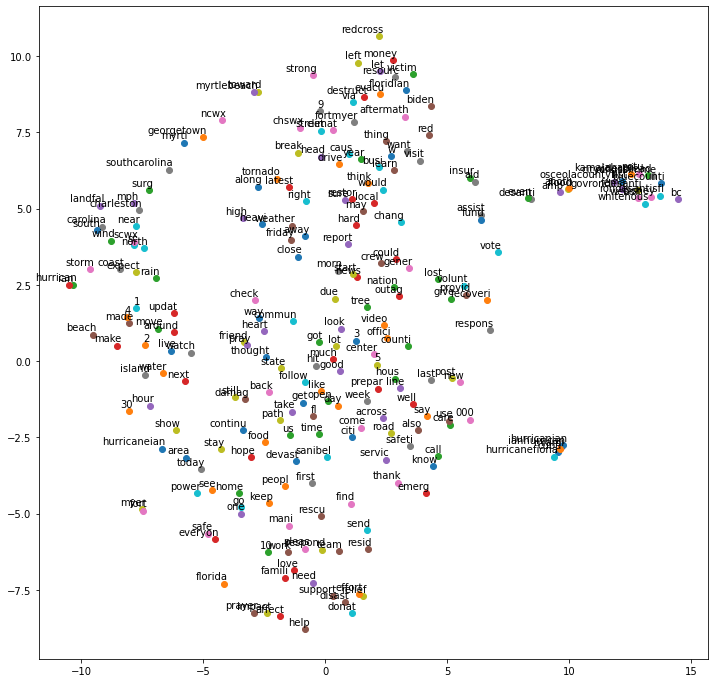

In [ ]:
sentences = clean_tweets
model = Word2Vec(sentences, workers=4, min_count=50, window=10, sample=1e-3)
tsne_plot(model)

# Part 3: Ranking

Defining all necessary functions

In [ ]:
def rank_documents_ours(terms, docs, index, idf, tf, likes, retweets, hashtags):
    """
    Perform the ranking of the results of a search based on the tf-idf+popolarity over social network weights
    
    Argument:
    terms -- list of query terms
    tweets -- list of tweets, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    likes -- dictionary with number of likes per doc
    retweets -- dictionary with number of retweets per doc
    hashtags -- dictionary with list of hashtags per doc

    Returns:
    Print the list of ranked tweets
    scores of the documents
    """
    # I'm interested only on the element of the tweetVector corresponding to the query terms 
    # The remaining elements would become 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call tweet_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    query_norm = la.norm(list(query_terms_count.values()))
    
    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
          continue
        
        avg_likes = sum(likes.values())/4000
        avg_retweets = sum(retweets.values())/4000
        
        ## Compute tf*idf(normalize TF as done with tweets)
        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term] 

        # Generate tweet_vectors for matching tweets
        for doc_index, (doc, postings) in enumerate(index[term]):

            if doc in docs:
                nlikes = likes[doc]
                nretweets = retweets[doc]
                if term in hashtags[doc]:
                  h=1
                else:
                  h=0
                w=0.1
                popularity = (w+w*h)*math.log2(( 1 + (nlikes/avg_likes + nretweets/avg_retweets) ))
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term] + popularity 
    
    # Calculate the score of each doc     
    doc_scores=[[np.sum(curDocVec), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    result_scores = [x[0] for x in doc_scores]
    if len(result_docs) == 0:
        print("No results found, try again")

    return result_docs, result_scores

In [ ]:
def search_ours(query, index, likes, retweets, hashtags):
    """
    output is the list of documents that contain all of the query terms. 
    So, we will get the list of documents for each query term, and take the intersaction of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs = [posting[0] for posting in index[term]]
            
            # docs = docs Intersaction term_docs
            if len(docs) == 0:
              docs = set(term_docs)
            else:
              docs.intersaction(set(term_docs))
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs, result_scores = rank_documents_ours (query, docs, index, idf, tf, likes, retweets, hashtags)
    return ranked_docs, result_scores

In [ ]:
def rank_documents_bm25 (terms, docs, index, idf, tf, k1, b, N, doc_length, lavg):
    """
    Perform the ranking of the results of a search based on the BM25 weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    k1 -- tunning parameter controling document term frequency scaling
    b -- tunning parameter controling the scaling by document length
    N -- number of documents
    doc_lenght -- dictionary with lenghts of all documents
    lavg -- average document length in the whole collection
    
    Returns:
    list of ranked documents
    scores of the documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    
    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue
            
        dft = len(index[term]) #in how many documents does it appear
        
        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):

            if doc in docs:
                ld = doc_length[doc] #document length
                doc_vectors[doc][termIndex] = np.log(N/dft) * (((k+1)*tf[term][doc_index]) / (k1*((1-b)+b*( ld / lavg ) ) + tf[term][doc_index]))
                
    # Calculate the score of each doc     
    doc_scores=[[np.sum(curDocVec), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    result_scores = [x[0] for x in doc_scores]
    if len(result_docs) == 0:
        print("No results found, try again")

    return result_docs, result_scores

In [ ]:
def search_bm25(query, index, k1, b, N, doc_length, lavg):
    """
    output is the list of documents that contain all of the query terms. 
    So, we will get the list of documents for each query term, and take the intersaction of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs = [posting[0] for posting in index[term]]
            
            # docs = docs Intersaction term_docs
            if len(docs) == 0:
              docs = set(term_docs)
            else:
              docs.intersaction(set(term_docs))
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs, result_scores = rank_documents_bm25 (query, docs, index, idf, tf, k1, b, N, doc_length, lavg)
    return ranked_docs, result_scores

In [ ]:
def rank_documents_word2vec (terms, docs, v_size):
    """
    Perform the ranking of the results of a search based on word2vec
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    
    Returns:
    list of ranked documents
    scores of the documents
    """
    tweet2vec = {'doc_id': docs}
    
    # Computing a vector for each word
    sentence = []
    for i, row in df_final.iterrows(): # for each tweet
      sentences.append(row['Tweet'])
    model = Word2Vec(sentences, vector_size=100)
    
    for i, row in df_final.iterrows():
      if row['doc_id'] in docs:
        doc_vector = [model.wv[word] for word in row['Tweet']]
        tweet2vec[row['doc_id']]=np.mean(doc_vector, axis=0)
        
    # Computing the vector for the query
    query2vec = [model.wv[word] for word in query if word in model.wv.key_to_index]
    query2vec = np.mean(query2vec, axis=0)  
    
    # Calculate the score of each doc     
    doc_scores=[[np.dot(curDocVec, query2vec), doc] for doc, curDocVec in tweet2vec.items() if doc in docs]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    result_scores = [x[0] for x in doc_scores]
    if len(result_docs) == 0:
        print("No results found, try again")

    return result_docs, result_scores

In [ ]:
def search_word2vec(query, index, vector_size):
    """
    output is the list of documents that contain all of the query terms. 
    So, we will get the list of documents for each query term, and take the intersaction of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs = [posting[0] for posting in index[term]]
            
            # docs = docs Intersaction term_docs
            if len(docs) == 0:
              docs = set(term_docs)
            else:
              docs.intersaction(set(term_docs))
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs, result_scores = rank_documents_word2vec (query, docs, vector_size)
    return ranked_docs, result_scores

TF-IDF + cosine similarity

In [ ]:
ranked_docs = [0]*5
result_scores = [0]*5
i = 0
for query in queries:
  ranked_docs[i], result_scores[i] = search_tf_idf(query, index)
  top = 20
  print("\n======================\nTop {} results out of {} for the searched query {}:\n".format(top, len(ranked_docs[i]), query))
  
  j=0
  for j in range(len(ranked_docs[i])):
    if (j < top):
      print("page_id = {}\t score = {}".format(ranked_docs[i][j], result_scores[i][j]))
  i+=1


Top 20 results out of 887 for the searched query florida wind:

page_id = doc_2950	 score = 2.540536110556786
page_id = doc_1493	 score = 2.3304000557827624
page_id = doc_2945	 score = 2.074244273523032
page_id = doc_32	 score = 1.9204901084610542
page_id = doc_1170	 score = 1.9204901084610542
page_id = doc_153	 score = 1.8551086644393724
page_id = doc_198	 score = 1.7961935170791754
page_id = doc_2047	 score = 1.7577887386602347
page_id = doc_242	 score = 1.72351185825636
page_id = doc_206	 score = 1.6934512479022468
page_id = doc_746	 score = 1.532105320077802
page_id = doc_3885	 score = 1.4980253932440322
page_id = doc_2794	 score = 1.4980253932440322
page_id = doc_716	 score = 1.4369548136633405
page_id = doc_3950	 score = 1.4089341947969052
page_id = doc_3388	 score = 1.4089341947969052
page_id = doc_3108	 score = 1.3579222989118567
page_id = doc_1652	 score = 1.3579222989118567
page_id = doc_1649	 score = 1.3579222989118567
page_id = doc_1249	 score = 1.3579222989118567

Top 20 

OUR-SCORE + cosine similarity

In [ ]:
likes = dict(zip(df_final['doc_id'], df_final['Likes']))
retweets = dict(zip(df_final['doc_id'], df_final['Retweets']))
hashtags = dict(zip(df_final['doc_id'], df_final['Hashtags']))

In [ ]:
ranked_docs = [0]*5
result_scores = [0]*5
i = 0
for query in queries:
  ranked_docs[i], result_scores[i] = search_ours(query, index, likes, retweets, hashtags)
  top = 20
  print("\n======================\nTop {} results out of {} for the searched query {}:\n".format(top, len(ranked_docs[i]), query))
  
  j=0
  for j in range(len(ranked_docs[i])):
    if (j < top):
      print("page_id = {}\t score = {}".format(ranked_docs[i][j], result_scores[i][j]))
  i+=1


Top 20 results out of 887 for the searched query florida wind:

page_id = doc_2794	 score = 1.839107458437128
page_id = doc_716	 score = 1.8058830801829893
page_id = doc_2047	 score = 1.7335627927139747
page_id = doc_3885	 score = 1.5975937362551926
page_id = doc_2950	 score = 1.5259608
page_id = doc_32	 score = 1.3295943272076056
page_id = doc_1665	 score = 1.3041395334919206
page_id = doc_1493	 score = 1.3007075499999998
page_id = doc_3636	 score = 1.264512088689496
page_id = doc_2945	 score = 1.24588485
page_id = doc_1170	 score = 1.15353315
page_id = doc_242	 score = 1.14163537
page_id = doc_992	 score = 1.1403873022251196
page_id = doc_2937	 score = 1.139758537479814
page_id = doc_1649	 score = 1.1393387930892622
page_id = doc_970	 score = 1.1391298730000627
page_id = doc_3296	 score = 1.131362649727497
page_id = doc_2036	 score = 1.1296827581337059
page_id = doc_153	 score = 1.1142621
page_id = doc_111	 score = 1.0965000473903097

Top 20 results out of 138 for the searched query

BM25

In [ ]:
# Ld
doc_length = dict()
for i, row in df_final.iterrows():
  doc_length[row['doc_id']]= len(row['Tweet'])

In [ ]:
# Lavg
lavg = 0
for length in doc_length.values():
  lavg+=length

lavg = round(lavg / len(doc_length))

In [ ]:
ranked_docs = [0]*5
result_scores = [0]*5
k1 = 2
b = 0.5
N = len(df_final)

i = 0
for query in queries:

  ranked_docs[i], result_scores[i] = search_bm25(query, index, k1, b, N, doc_length, lavg)
  top = 20
  print("\n======================\nTop {} results out of {} for the searched query {}:\n".format(top, len(ranked_docs[i]), query))
  
  j=0
  for j in range(len(ranked_docs[i])):
    if (j < top):
      print("page_id = {}\t score = {}".format(ranked_docs[i][j], result_scores[i][j]))
  i+=1


Top 20 results out of 887 for the searched query florida wind:

page_id = doc_2950	 score = 9.05556914360439
page_id = doc_2945	 score = 6.722223942775893
page_id = doc_32	 score = 5.922951635418267
page_id = doc_1170	 score = 5.922951635418267
page_id = doc_3296	 score = 5.626728038410951
page_id = doc_153	 score = 5.582166054734131
page_id = doc_1493	 score = 5.557941598193742
page_id = doc_3848	 score = 5.4204251025570604
page_id = doc_198	 score = 5.2744478898268925
page_id = doc_1615	 score = 5.249526232702441
page_id = doc_206	 score = 5.004556205523901
page_id = doc_111	 score = 4.914147201214987
page_id = doc_70	 score = 4.733786067347694
page_id = doc_470	 score = 4.733786067347694
page_id = doc_40	 score = 4.733786067347694
page_id = doc_3665	 score = 4.733786067347694
page_id = doc_3114	 score = 4.733786067347694
page_id = doc_2899	 score = 4.733786067347694
page_id = doc_1672	 score = 4.733786067347694
page_id = doc_1047	 score = 4.733786067347694

Top 20 results out of 13

Word2vec + cosine similarity 

In [ ]:
ranked_docs = [0]*5
result_scores = [0]*5
k1 = 2
b = 0.5
N = len(df_final)

i = 0
for query in queries:

  ranked_docs[i], result_scores[i] = search_word2vec(query, index, 100)
  top = 20
  print("\n======================\nTop {} results out of {} for the searched query {}:\n".format(top, len(ranked_docs[i]), query))
  
  j=0
  for j in range(len(ranked_docs[i])):
    if (j < top):
      print("page_id = {}\t score = {}".format(ranked_docs[i][j], result_scores[i][j]))
  i+=1


Top 20 results out of 887 for the searched query florida wind:

page_id = doc_2950	 score = 7.710783004760742
page_id = doc_2334	 score = 7.286983013153076
page_id = doc_1249	 score = 7.194722652435303
page_id = doc_242	 score = 7.1783246994018555
page_id = doc_3017	 score = 6.804672718048096
page_id = doc_3145	 score = 6.5900983810424805
page_id = doc_2190	 score = 6.571204662322998
page_id = doc_381	 score = 6.370839595794678
page_id = doc_2347	 score = 6.286569118499756
page_id = doc_575	 score = 6.196737289428711
page_id = doc_863	 score = 6.144175052642822
page_id = doc_3230	 score = 6.042823791503906
page_id = doc_3964	 score = 5.956198692321777
page_id = doc_2113	 score = 5.921611309051514
page_id = doc_57	 score = 5.8086395263671875
page_id = doc_330	 score = 5.786818504333496
page_id = doc_1731	 score = 5.772947311401367
page_id = doc_2901	 score = 5.65480375289917
page_id = doc_3481	 score = 5.636985778808594
page_id = doc_751	 score = 5.613426685333252

Top 20 results out o